<a href="https://colab.research.google.com/github/FabriDeCastelli/ISPR-23-24/blob/main/assignment3/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Contractive and Denoising Autoencoders

## Author: Fabrizio De Castelli

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow.keras as K
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import warnings


np.random.seed(42)
warnings.filterwarnings('ignore')

# comment all the following lines if run in local

"""
import sys

current_dir = %pwd
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

!git clone https://github.com/FabriDeCastelli/ISPR-23-24.git
os.chdir("ISPR-23-24/assignment3")
"""

# until here

# ------- GLOBAL VARIABLES -------
# MNIST dataset
MNIST_TRAINING_IMAGES_PATH = "dataset/train-images.idx3-ubyte"
MNIST_TRAINING_LABELS_PATH = "dataset/train-labels.idx1-ubyte"
MNIST_TEST_IMAGES_PATH = "dataset/t10k-images.idx3-ubyte"
MNIST_TEST_LABELS_PATH = "dataset/t10k-labels.idx1-ubyte"

# latent space dimension
LATENT_SPACE_DIMENSION = 128

#### Utilities

Here are the implemented utilities:
- `mnist`: loads the MNIST dataset
- `add_noise`: adds a gaussian noise of the form $\sim N(0, \sigma^2)$ to an input numpy array
- `generate_noise`: generates a random noise of the form $\sim N(0, \sigma^2)$
- `representative_images`: returns a set of representative images from the dataset. It is used to retrieve one image from all different classes in the MNIST dataset
- `plot_images`: plots the images in a grid

In [ ]:
def mnist(_set='training'):
    """
    Loads the MNIST dataset.

    :param _set: the set to load (either 'training' or 'test')

    :return: the images and the labels
    """

    if _set == 'training':
        images = MNIST_TRAINING_IMAGES_PATH
        labels = MNIST_TRAINING_LABELS_PATH
    elif _set == 'test':
        images = MNIST_TEST_IMAGES_PATH
        labels = MNIST_TEST_LABELS_PATH
    else:
        raise ValueError('Invalid set: provide either "training" or "test"')

    with open(images, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)

    with open(labels, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        _ = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return data.astype('float32') / 255., labels

def add_noise(data, noise=0.1):
    """
    Adds noise to the data.

    :param data: the data to add noise to
    :param noise: the noise to add to the data

    :return: the data with noise
    """
    noisy = data + noise * np.random.normal(loc=0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

def generate_noise(noise=0.1):
    """
    Generates noise to the data. The default noise is generated by a Normal distribution.

    :param noise: the noise to add to the data

    :return: the data with noise
    """
    noisy = noise * np.random.normal(loc=0, scale=1.0, size=(1, 784))
    return np.clip(noisy, 0., 1.)

def representative_images(data, targets, n=10):
    """
    Returns a representative image of the dataset.

    :param data: the images
    :param targets: the labels
    :param n: the number of representative images to return. Default is 10 (ten classes in MNIST)

    :return: n representative images, all of different classes
    """
    _, indices = np.unique(targets, return_index=True)
    return data[indices[:n]]

def plot_images(data, num_cols=10, title=""):
    """
    Plots the original and reconstructed images.

    :param data: the input data
    :param num_cols: the number of columns in the plot
    :param title: the title of the plot
    """
    num_images = len(data)
    num_rows = (num_images // num_cols) + (num_images % num_cols > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    fig.text(0.5, 0.84, title, ha='center', fontsize=14)
    # In case we have only one row, the axs variable is not a list => convert it to a list
    if num_rows == 1:
        axs = [axs]

    for i in range(num_images):
        ax = axs[i // num_cols][i % num_cols]
        ax.set_title(f'Image {i}')
        ax.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

    # Remove any empty subplots
    for i in range(num_images, num_cols * num_rows):
        fig.delaxes(axs[i // num_cols][i % num_cols])


    plt.tight_layout()
    plt.show()

## Models

The models are implemented using the Keras API. The encoder and decoders that are going to be used both for the DAE and DAE are the following:
- Feedforward with 3 layers of halving dimensions
- Convolutional (convolutional encoder and deconvolutional decoder) with 3 Conv2D\[Transpose\] layers and 1 Dense bottleneck

All models use ReLU activation function for the hidden layers and the Sigmoid activation function for the output layer.


In [ ]:
ff_encoder = K.models.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(LATENT_SPACE_DIMENSION * 4, activation='relu'),
    layers.Dense(LATENT_SPACE_DIMENSION * 2, activation='relu'),
    layers.Dense(LATENT_SPACE_DIMENSION, activation='relu'),
])

ff_decoder = K.models.Sequential([
    layers.Input(shape=(LATENT_SPACE_DIMENSION,)),
    layers.Dense(LATENT_SPACE_DIMENSION * 2, activation='relu'),
    layers.Dense(LATENT_SPACE_DIMENSION * 4, activation='relu'),
    layers.Dense(784, activation='sigmoid')
])

convolutions = K.models.Sequential([
    layers.Input(shape=(784,)),
    layers.Reshape((28, 28, 1)), # 28x28x1
    layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same'),  # 14x14x32
    layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'),  # 7x7x64
    layers.Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='valid'),  # 3x3x128
    layers.Flatten(), # 1152x1
    layers.Dense(10, activation='relu') # 10x1
], name="encoder")


deconvolutions = K.models.Sequential([
    layers.Input(shape=(10,)),
    layers.Dense(3*3*128, activation='relu'), # 1152x1
    layers.Reshape((3, 3, 128)), # 3x3x128
    layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='valid'),  # 7x7x64
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),  # 14x14x32
    layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same'),  # 28x28x1
    layers.Flatten() # 784x1
], name="decoder")



## Deep Autoencoders

The first class of this cell represents an Autoencoder. It is a subclass of the Keras Model class, in order to efficiently use their API when compiling and training an instantiated object. Apart from the constructor and some overridden methods that is used for model serialization, the class implements a method for generating images from noise with a given number of steps and a method for plotting the 2D manifold of generated images. This class is going to be used both for the Denoising AE and the Contractive AE, as they share everything but the loss at compile time.
At the end of the training we can classify the encoded data using a Logistic Regression model (sklearn), in order to see how well the model has learned the latent space.

The second class is a subclass of keras' Callback API that is used to plot the latent space of the model across the epochs. It is used to save images every 5 epochs during the training phase, in order to build and save a gif from them at the end of the training (`on_train_end` method).


In [ ]:
@tf.keras.utils.register_keras_serializable()
class Autoencoder(Model):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.classifier = LogisticRegression(max_iter=1000)


    def call(self, inputs, **kwargs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

    def generate(self, steps=15, noise=0.1):
        """
        Generates images from noise.

        :param steps: number of steps to generate the images
        :param noise: the noise to add to the data
        """
        noise_image = generate_noise(noise=noise)
        for _ in range(steps):
         noise_image = self.predict(noise_image, verbose=0)
        return noise_image

    def classify(self, data, targets):
        """
        Fits a logistic regression model to the encoded data.

        :param data: the data to fit the model
        :param targets: the targets to fit the model
        """
        latent = self.encoder(data)
        self.classifier.fit(latent, targets)
        return self.classifier.score(latent, targets) * 100

    def plot_generations(self, steps=15, num_images=10, noise=0.1):

        assert num_images > 0
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
        for i in range(num_images):

            generation = self.generate(steps=steps, noise=noise)
            ax = axes[i]
            ax.imshow(generation.reshape(28, 28), cmap='gray')
            ax.axis('off')

        plt.show()


    def plot_manifold(self, n=30, figsize=10, steps=15, max_scale=1.0):
        """
        Plots a 2D manifold of digits in the latent space

        :param n: number of digits to plot in the manifold
        :param figsize: size of the figure
        :param steps: number of steps to generate the manifold
        :param max_scale: the maximum scale of the manifold

        """
        digit_size = 28
        scale = max_scale
        figure = np.zeros((digit_size * n, digit_size * n))

        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                generation = self.generate(steps=steps, noise=(xi + yi) / 2)

                digit = generation[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.imshow(figure, cmap="Greys_r")
        plt.show()

    @classmethod
    def load(cls, path, encoder, decoder):
        """
        Loads the model from a file.

        :param path: the path to the file
        :param encoder: the encoder model
        :param decoder: the decoder model
        """
        m = tf.keras.models.load_model(path, compile=False)
        new_instance = cls(encoder, decoder)
        new_instance.set_weights(m.get_weights())
        return new_instance

    def get_config(self):
        return {
            "encoder": self.encoder,
            "decoder": self.decoder,
        }

    @classmethod
    def from_config(cls, config, **kwargs):
        return cls(**config)

class PlotCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, directory):
        super().__init__()
        os.makedirs(directory, exist_ok=True)
        self.directory = directory
        self.validation_data, self.validation_targets = validation_data

    def on_train_begin(self, logs=None):
        for f in os.listdir(self.directory):
            os.remove(f'{self.directory}/{f}')

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        self.plot_latent_space(epoch)

    def plot_latent_space(self, epoch):

        latent = self.model.encoder(self.validation_data)
        latent = TSNE(n_components=2).fit_transform(latent)
        # plot the latent space
        plt.figure(figsize=(10, 10))
        sns.scatterplot(x=latent[:, 0], y=latent[:, 1], hue=self.validation_targets, palette='tab10')
        plt.savefig(f'{self.directory}/epoch_{epoch + 1}.png')
        plt.close()

    def on_train_end(self, logs=None):
        self.plot_latent_space(epoch=25)
        self.save_gif( 'latent_space')

    def save_gif(self, gif_name):
        assert os.path.isdir(self.directory), "The path is not a directory"
        assert any([f.endswith('.png') for f in os.listdir(self.directory)]), \
            "The directory must contain only images"

        frames = []
        images = sorted(
            list(filter(lambda x: x.endswith('.png'), os.listdir(self.directory))),
            key=lambda x: int(x.split('_')[-1].split('.')[0])
        )

        for image in images:
            frames.append(imageio.imread(f'{self.directory}/{image}'))

        imageio.mimsave(f'{self.directory}/{gif_name}.gif', frames, 'GIF', duration=1500)

## Data Preparation

The following cell loads the MNIST dataset and adds noise to the images. The images are perturbed with a noise factor of 0.7, shared among all experiments. The `early_stopping` callback is used to stop the training when the validation loss does not improve for 3 epochs. The `zero_to_ten` variable is used to retrieve one image from each class in the MNIST dataset, in order to plot the original and reconstructed images and the latent space of the models.

The following cells are going to be almost equal, but with different models, and the following steps are going to be repeated:
- Model training
- Model and classifier evaluation
- Image generation from noise
- 2D manifold plotting

In [ ]:
# load the MNIST dataset
training_images, training_labels = mnist('training')
test_images, test_labels = mnist('test')

# add noise to the data
noise_factor = 0.7
training_noisy_images = add_noise(training_images, noise_factor)
test_noisy_images = add_noise(test_images, noise_factor)

# common testing and training details
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
zero_to_ten = representative_images(test_images, test_labels)


## Denoising Autoencoder

A denoising autoencoder is a feedforward autoencoder that is trained to remove noise from the input data. The model is trained with noisy images as input and the original images as output. The loss function is the mean squared error between the original and the reconstructed image.

In this assignment, we are going to compare the performance of a feedforward denoising autoencoder with a convolutional denoising autoencoder. We will train both models with the same noise factor and evaluate them on the test set. We will also plot the original and reconstructed images and the latent space of the models.

## Denoising Autoencoder (Feedforward)

In [ ]:
ff_denoising_autoencoder = Autoencoder(ff_encoder, ff_decoder)
ff_denoising_autoencoder.compile(optimizer="adam", loss="mean_squared_error")
plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/feed_forward/denoising_autoencoder")

_ = ff_denoising_autoencoder.fit(
    training_noisy_images,
    training_images,
    epochs=25,
    batch_size=100,
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=0
)

ff_denoising_autoencoder.save("models/feed_forward/denoising_autoencoder")

test_loss = ff_denoising_autoencoder.evaluate(test_noisy_images, test_images, verbose=0)
print(f'Test loss: {test_loss}')

Test loss: 0.02135760709643364


## Results interpretation

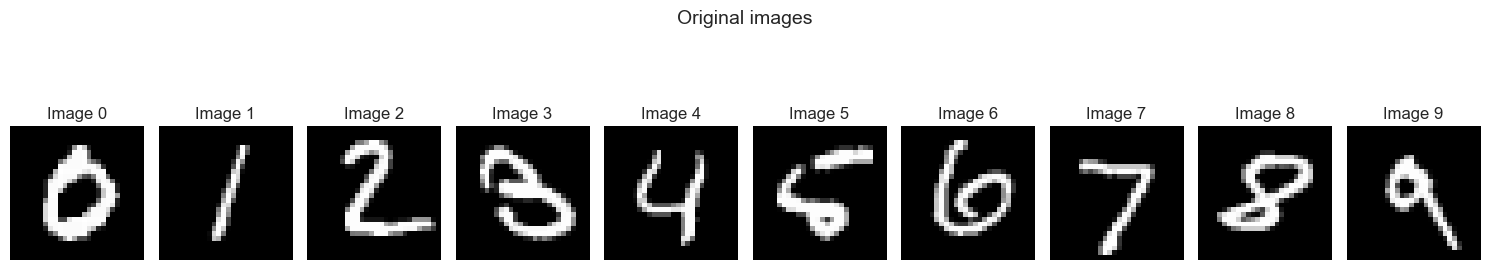

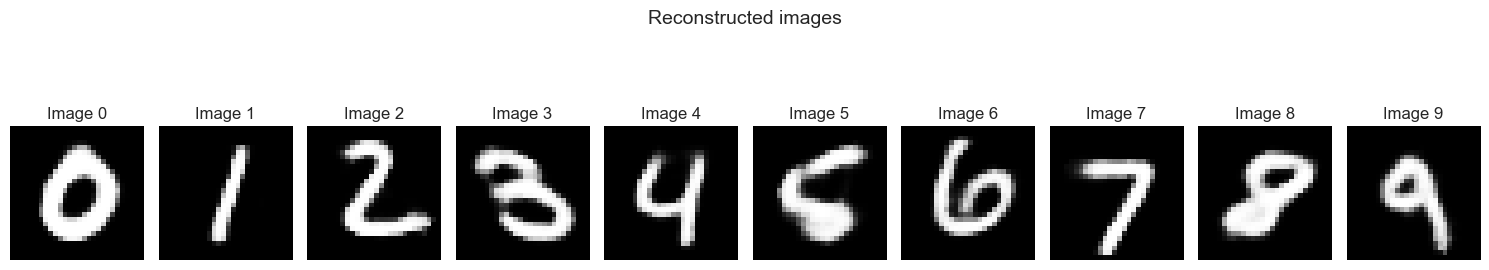

In [ ]:
ff_denoising_autoencoder = Autoencoder.load("models/feed_forward/denoising_autoencoder", ff_encoder, ff_decoder)
zero_to_ten_reconstruction = ff_denoising_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

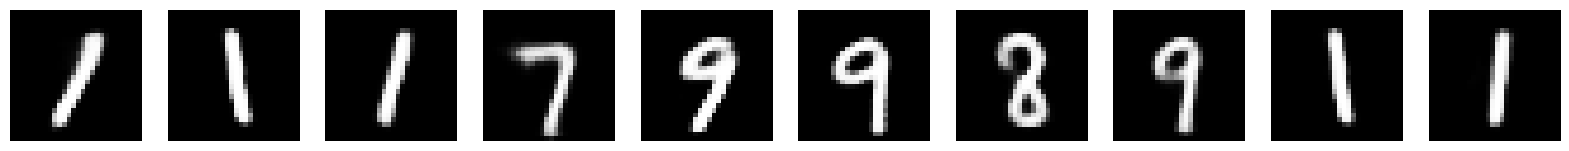

In [ ]:
ff_denoising_autoencoder.plot_generations(noise=noise_factor, steps=4)

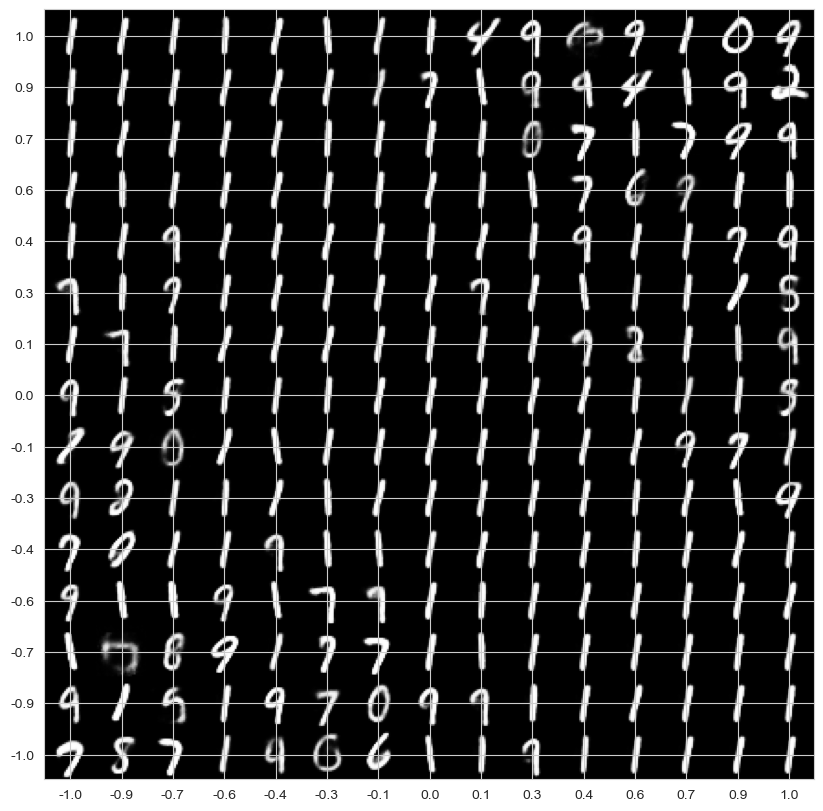

In [ ]:
ff_denoising_autoencoder.plot_manifold(n=15, steps=4, max_scale=1)

## Denoising Autoencoder (Convolutional)

In [ ]:
conv_denoising_autoencoder = Autoencoder(convolutions, deconvolutions)

conv_denoising_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/convolutional/denoising_autoencoder")

_ = conv_denoising_autoencoder.fit(
    training_noisy_images,
    training_images,
    epochs=25,
    batch_size=100,
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=0
)

test_loss = conv_denoising_autoencoder.evaluate(test_noisy_images, test_images, verbose=0)
print(f'Test loss: {test_loss}')

Test loss: 0.02748308703303337


## Results interpretation

The reconstruction could

In [ ]:
conv_denoising_autoencoder.save("models/convolutional/denoising_autoencoder")

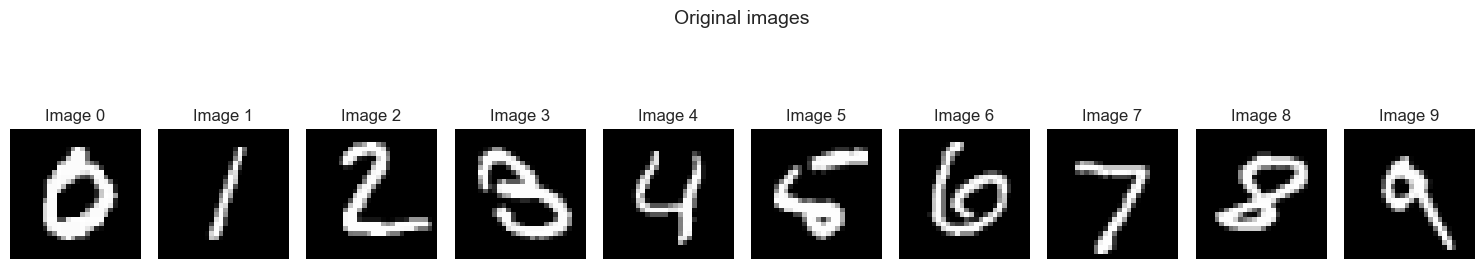

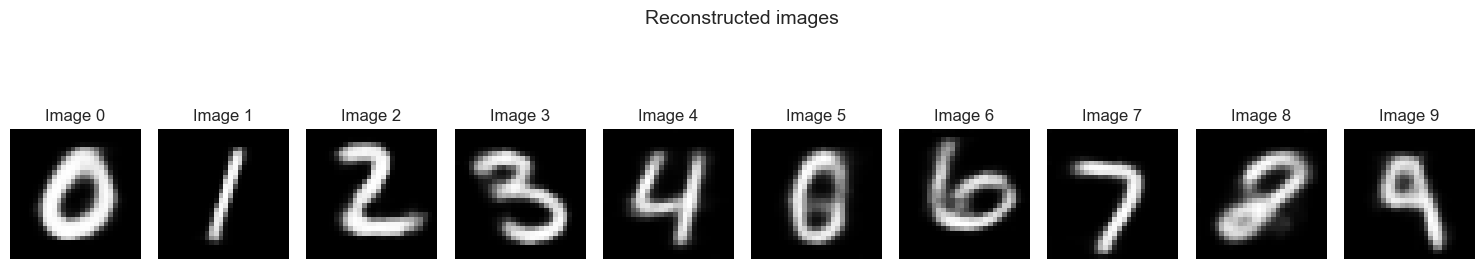

In [ ]:
# Plot the original and reconstructed images
conv_denoising_autoencoder = Autoencoder.load("models/convolutional/denoising_autoencoder", convolutions, deconvolutions)
zero_to_ten = representative_images(test_images, test_labels)
zero_to_ten_reconstruction = conv_denoising_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

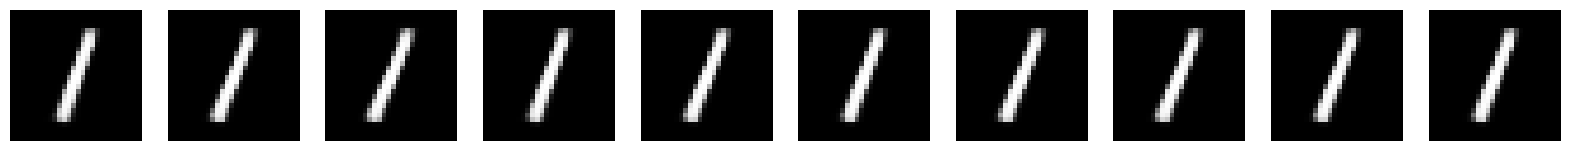

In [ ]:
conv_denoising_autoencoder.plot_generations(noise=noise_factor)

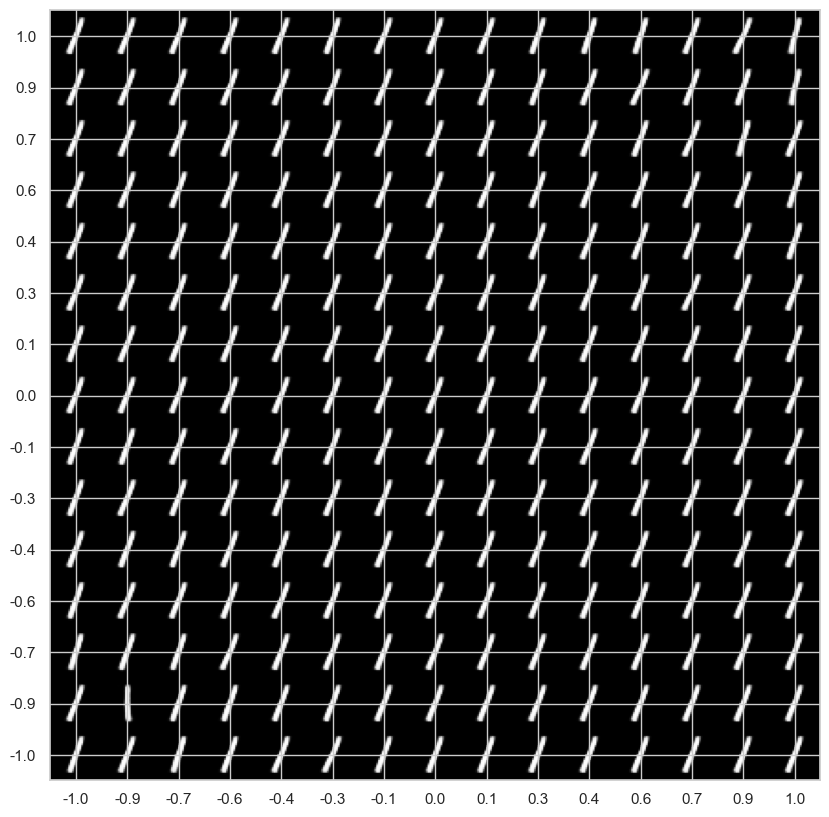

In [ ]:
conv_denoising_autoencoder.plot_manifold(n=15, max_scale=1)

## Contractive Autoencoder

The contractive autoencoder is a feedforward autoencoder that is trained with an additional regularization term in the loss function. This regularization term is the Frobenius norm of the Jacobian of the encoder with respect to the input. The loss function is defined as follows:

$$
\mathcal{L} = \text{MSE} + \lambda \cdot \left\| \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right\|_F^2
$$

where $\mathbf{z}$ is the latent representation of the input $\mathbf{x}$, $\text{MSE}$ is the mean squared error between the original and the reconstructed image, and $\lambda$ is the regularization parameter. The Frobenius norm is computed as the sum of the squared elements of the Jacobian matrix.

However, since the Jacobian computation is very slow even in batches and with the additional @tf.function decorator, we followed the suggestions from _Towards Deep Neural Network Architectures Robust to Adversarial Examples\[section 4.2\]_ ([link here](https://arxiv.org/pdf/1412.5068)) and rather than computing the Jacobian, we compute the gradient of the latent representation with respect to the input. This is still a good approximation of the Frobenius norm of the Jacobian, and it is much faster to compute.

As mentioned before, we want to compare the deep convolutional autoencoder with the deep feedforward autoencoder. We will train both models with the contractive loss and evaluate them on the test set. We will also plot the original and reconstructed images and the latent space of the models.


In [ ]:
def contractive_loss(encoder, lam):

    @tf.function
    def loss(reconstruction, original):
        mse = losses.MeanSquaredError()(reconstruction, original)
        with tf.GradientTape() as tape:
            tape.watch(original)
            z = encoder(original)
        encoding_gradients = tape.gradient(z, original)
        frobenius_norm = tf.reduce_sum(tf.square(encoding_gradients), axis=1)
        return mse + lam * frobenius_norm

    return loss

## Contractive Autoencoder (Feedforward)

In [ ]:
ff_contractive_autoencoder = Autoencoder(encoder=ff_encoder, decoder=ff_decoder)

contractive_l = contractive_loss(ff_contractive_autoencoder.encoder, 1e-4)

ff_contractive_autoencoder.compile(optimizer='adam', loss=contractive_l)

plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/feed_forward/contractive_autoencoder")

_ = ff_contractive_autoencoder.fit(
    training_noisy_images,
    training_images,
    epochs=25,
    batch_size=100,
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=0
)

ff_contractive_autoencoder.save("models/feed_forward/contractive_autoencoder")

ff_contractive_autoencoder.evaluate(test_noisy_images, test_images, verbose=0)

0.021680017933249474

## Results interpretation

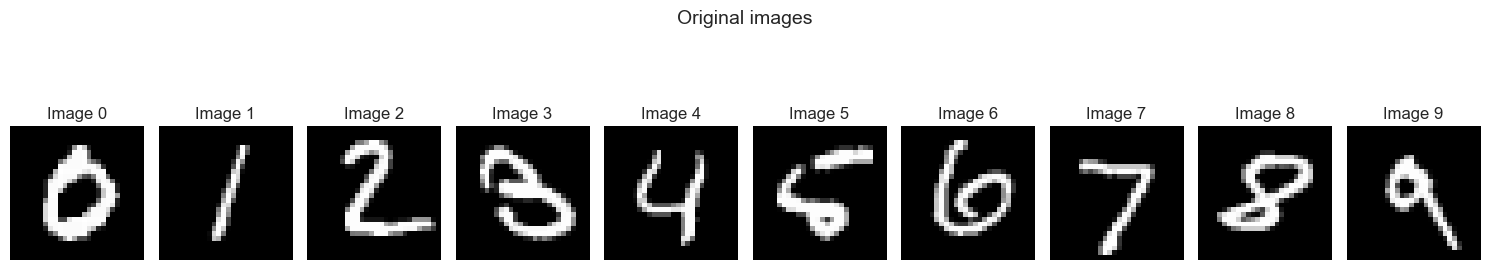

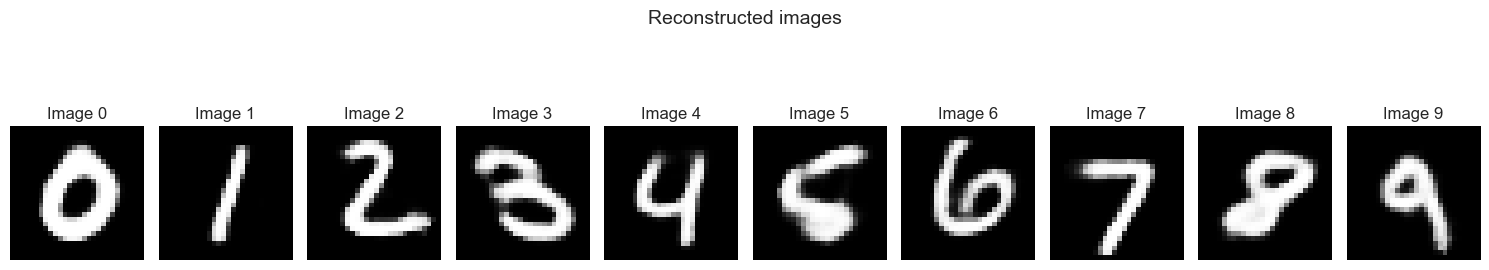

In [ ]:
# Plot the original and reconstructed images
ff_contractive_autoencoder = Autoencoder.load("models/feed_forward/contractive_autoencoder", ff_encoder, ff_decoder)
zero_to_ten_reconstruction = ff_contractive_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

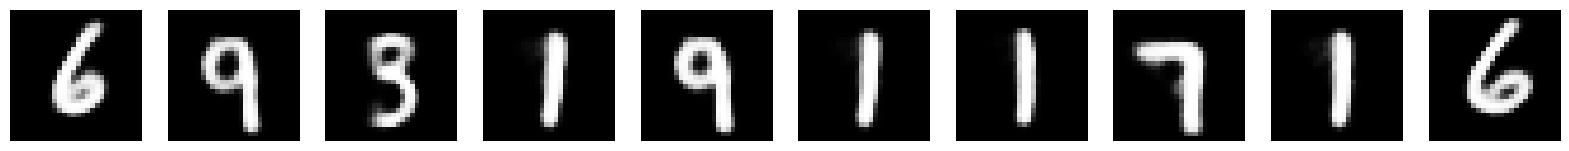

In [ ]:
ff_contractive_autoencoder.plot_generations(noise=noise_factor, steps=6)

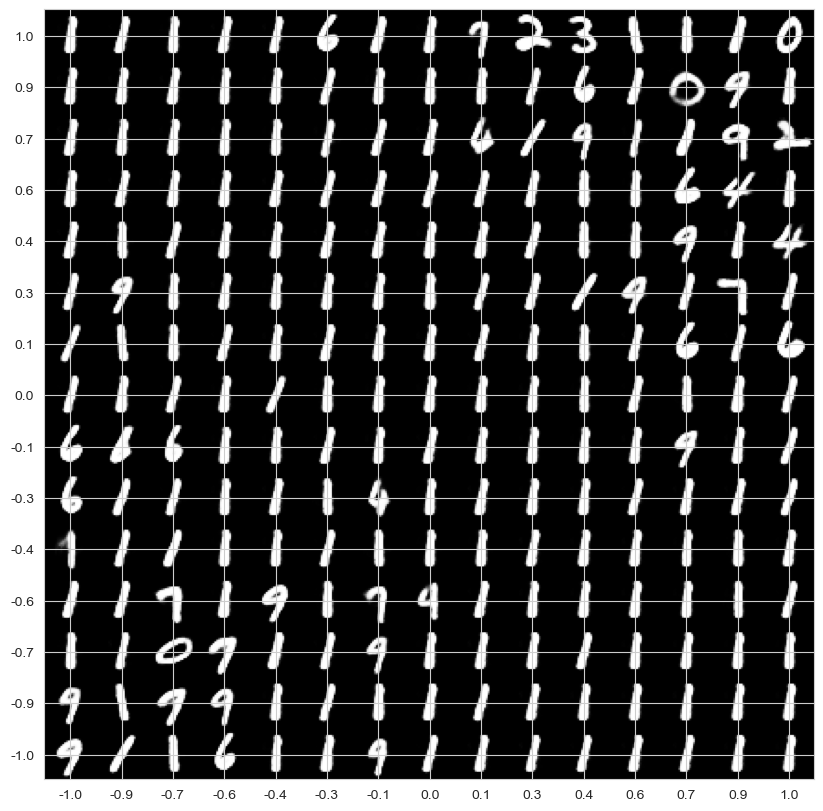

In [ ]:
ff_contractive_autoencoder.plot_manifold(n=15, max_scale=1, steps=6)

## Convolutional Contractive Autoencoder

In [ ]:
conv_contractive_autoencoder = Autoencoder(convolutions, deconvolutions)

contractive_l = contractive_loss(conv_contractive_autoencoder.encoder, 1e-4)

conv_contractive_autoencoder.compile(optimizer='adam', loss=contractive_l)

plot_checkpoint = PlotCheckpoint((test_noisy_images, test_labels), "plots/convolutional/contractive_autoencoder")

_ = conv_contractive_autoencoder.fit(
    training_noisy_images,
    training_images,
    batch_size=100,
    epochs=25,
    shuffle=True,
    callbacks=[early_stopping, plot_checkpoint],
    validation_data=(test_noisy_images, test_images),
    verbose=0
)

conv_contractive_autoencoder.save("models/convolutional/contractive_autoencoder")

conv_contractive_autoencoder.evaluate(test_noisy_images, test_images, verbose=0)

0.02853046916425228

## Results interpretation

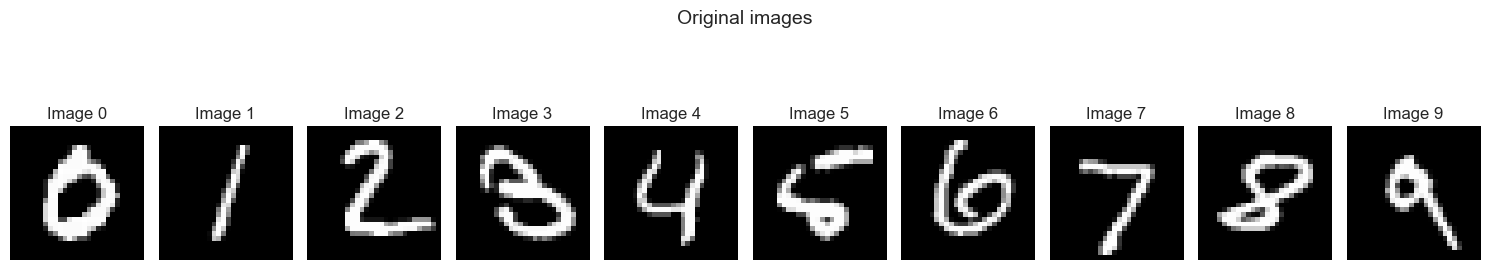

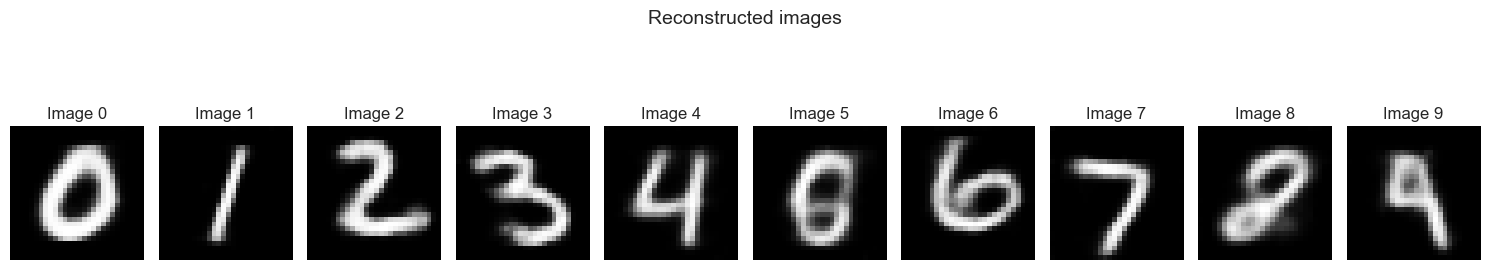

In [ ]:
# Plot the original and reconstructed images
# conv_contractive_autoencoder = Autoencoder.load("models/convolutional/contractive_autoencoder", convolutions, deconvolutions)
zero_to_ten_reconstruction = conv_contractive_autoencoder.predict(zero_to_ten, verbose=0)
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

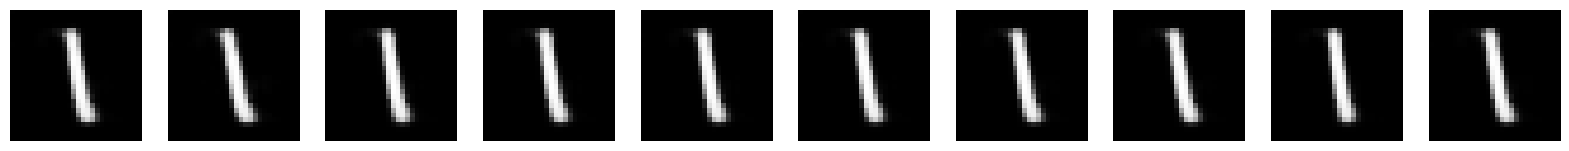

In [ ]:
conv_contractive_autoencoder.plot_generations(noise=noise_factor)

## An interesting curiosity

When we generate images from noise, the model seems to have a wider variety of generation when we generate from a higher noise. This might be due to the fact that the model is more likely to generate different images from the same noise, as the noise is more significant. This is shown in the following plot, where we generate images from noise with a rescaled gaussian $N(0, 7^2)$.

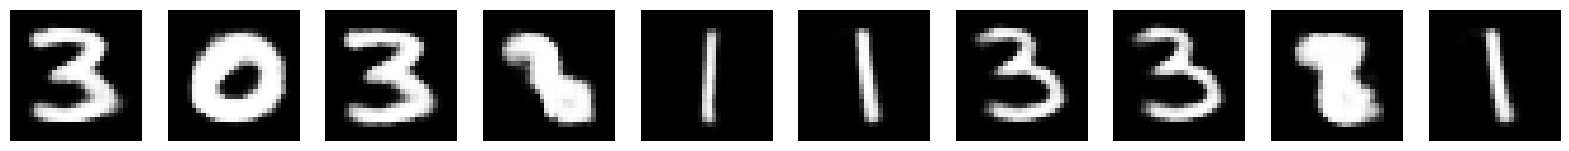

In [ ]:
conv_contractive_autoencoder.plot_generations(noise=7)

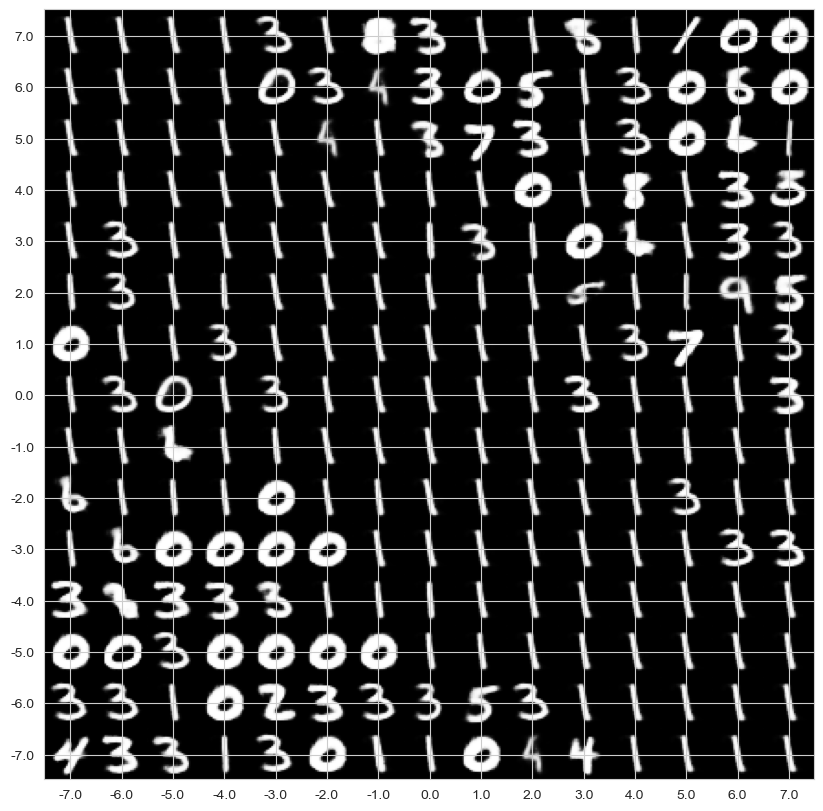

In [ ]:
conv_contractive_autoencoder.plot_manifold(n=15, max_scale=7)

### The Latent Space Organization

I had a lot of fun creating gifs from the latent space of the models. The following gifs show the latent space of the models across the epochs. The latent space is computed using the t-SNE algorithm from _Visualizing Data using t-SNE_ ([link here](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)), and the images are colored according to their class. The latent space of the models is quite well organized, as the images of the same class are close to each other. This is a good sign that the models have learned a good representation of the data.


<table>
  <tr>
    <th></th>
    <th>Feed Forward</th>
    <th>Convolutional</th>
  </tr>
  <tr>
    <th>DAE</th>
    <td><img src="https://github.com/FabriDeCastelli/ISPR-23-24/blob/main/assignment3/plots/feed_forward/denoising_autoencoder/latent_space.gif?raw=true" width="200px"></td>
    <td><img src="https://github.com/FabriDeCastelli/ISPR-23-24/blob/main/assignment3/plots/convolutional/denoising_autoencoder/latent_space.gif?raw=true" width="200px"></td>
  </tr>
  <tr>
    <th>CAE</th>
    <td><img src="https://github.com/FabriDeCastelli/ISPR-23-24/blob/main/assignment3/plots/feed_forward/contractive_autoencoder/latent_space.gif?raw=true" width="200px"></td>
    <td><img src="https://github.com/FabriDeCastelli/ISPR-23-24/blob/main/assignment3/plots/convolutional/contractive_autoencoder/latent_space.gif?raw=true" width="200px"></td>
  </tr>
</table>



### Classification Results

The following plot shows the classification accuracy of the models on the test set. The accuracy is computed using a Logistic Regression model on the encoded data, in a hold-out fashion.

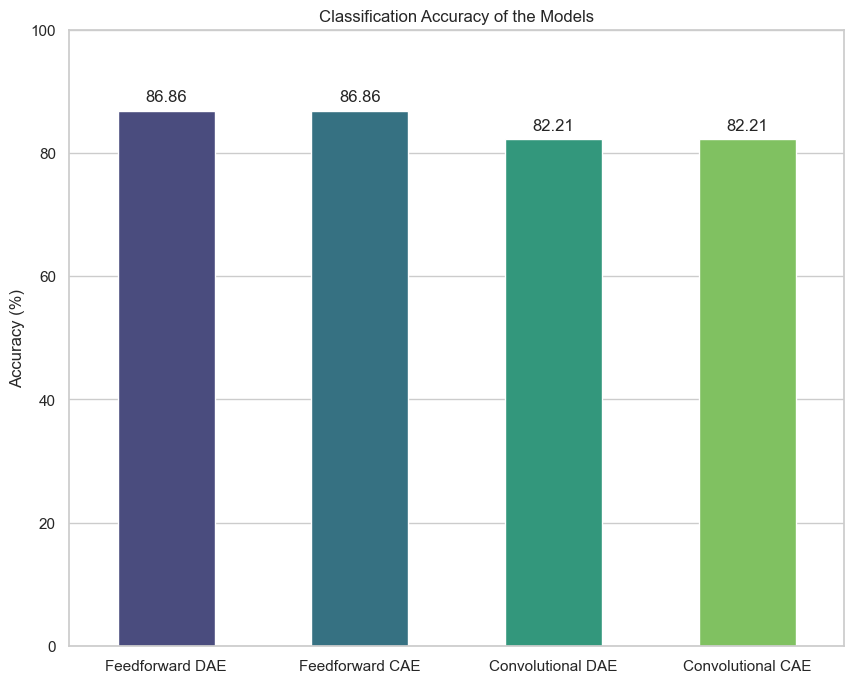

In [ ]:
a = Autoencoder.load("models/feed_forward/denoising_autoencoder", ff_encoder, ff_decoder)
b = Autoencoder.load("models/convolutional/denoising_autoencoder", convolutions, deconvolutions)
c = Autoencoder.load("models/feed_forward/contractive_autoencoder", ff_encoder, ff_decoder)
d = Autoencoder.load("models/convolutional/contractive_autoencoder", convolutions, deconvolutions)

ACCURACIES = {
    "Feedforward DAE": a.classify(test_noisy_images, test_labels),
    "Convolutional DAE": b.classify(test_noisy_images, test_labels),
    "Feedforward CAE": c.classify(test_noisy_images, test_labels),
    "Convolutional CAE": d.classify(test_noisy_images, test_labels)
}

ACCURACIES = dict(sorted(ACCURACIES.items(), key=lambda x: x[1], reverse=True))


plt.figure(figsize=(10, 8))
sns.set_context('notebook')
sns.barplot(x=list(ACCURACIES.keys()), y=list(ACCURACIES.values()), palette='viridis', width=0.5)
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy of the Models")

for i, acc in enumerate(ACCURACIES.values()):
    plt.text(i, acc + 1, f'{acc:.2f}', ha='center', va='bottom')


plt.ylim(0, 100)
plt.show()
plt.close()

## Conclusions

In this assignment, we implemented ...